In [1]:
%%html
<!-- left align tables -->
<style>
table {margin-left: 0 !important;}
</style>

# Identify Persons of Interest in the Enron Corpus Dataset

## Introduction

The Enron Corporation was one of the largest copmanies in the world energy sector during the 1990s and the early 2000s. At the end of the year 2001 it was revealed that senior Enron managers had used fraudulent accounting techniques to hide their losses in high-risk deals. This has since been known as the Enron scandal and finally led to the bankruptcy of Enron. During the federal investigations of that case records containing financial data of its top executives as well as hundred thousands of emails have been made public.

In this project, I used parts of this data to build a machine learning algorithm to identify employees that have partaken in the fraud case. These persons of interest (POIs) are individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. 

Throughout this report I have used several helper functions for data wrangling, printing tables and plotting. Their code can be found [here](https://github.com/ttsteiger/Udacity_DAND/blob/master/DAND_p5/helper_functions.py) and should be used to follow along with the project.

In [2]:
# import packages
import warnings
warnings.filterwarnings("ignore") # hide warnings in cell output

from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from helper_functions import convert_dict_to_df, print_classifier_table, scatter_plot, generate_meshgrid, \
plot_boundaries

## Data Exploration

### Dataset Description

The underlying dataset for this project is a combination of Enron email and financial data. The data is present in the precompiled `enron_dataset.pkl` file where it is stored in a dictionary structure. Each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. For easier handling, I converted the dcitionary to a pandas `DataFrame` after the import.

The original Enron data can be found only using the following links:

* Email Data (https://www.cs.cmu.edu/~./enron/)
* Financial Data (http://news.findlaw.com/hdocs/docs/enron/enron61702insiderpay.pdf)

In [3]:
# load dictionary containing the dataset
with open("data/enron_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

# feature list
features = ['poi', 'bonus', 'deferral_payments', 'deferred_income', 
            'director_fees', 'exercised_stock_options', 'expenses', 
            'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 
            'restricted_stock_deferred', 'salary', 'total_payments', 
            'total_stock_value', 'email_address', 'from_messages', 
            'from_poi_to_this_person', 'from_this_person_to_poi', 
            'shared_receipt_with_poi', 'to_messages']

# convert specified features to data frame
data_df = convert_dict_to_df(data_dict, features, remove_NaN=False, 
                        remove_all_zeroes=True, remove_any_zeroes=False, 
                        sort_keys=True)

The dataset contains information about 146 different data points. Of those, 18 are marked as POI. It also contains three major feature categories: POI labels, financial features and email features. The 22 feature names and their types are described in the table below.

| Feature                   | Type        |
|-------------------------- | ----------- |
| name                      | text        |
| poi                       | categorical |
| bonus                     | numerical   |
| deferral_payments         | numerical   |
| deferred_income           | numerical   |
| director_fees             | numerical   |
| exercised_stock_options   | numerical   |
| expenses                  | numerical   |
| loan_advances             | numerical   |
| long_term_incentive       | numerical   |
| other                     | numerical   |
| restricted_stock          | numerical   |
| restricted_stock_deferred | numerical   |
| salary                    | numerical   |
| total_payments            | numerical   |
| total_stock_value         | numerical   |
| email_address             | text        |
| from_messages             | numerical   |
| from_poi_to_this_person   | numerical   |
| from_this_person_to_poi   | numerical   |
| shared_receipt_with_poi   | numerical   |
| to_messages               | numerical   |

In a next step, I had a look at missing data within the different input features that could be used for the machine learning model.

In [4]:
# count number of NaN values in each column
print("Number of NaN values in each columns:")
print("-------------------------------------")
print(data_df.isnull().sum())

Number of NaN values in each columns:
-------------------------------------
name                           0
poi                            0
bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
exercised_stock_options       44
expenses                      51
loan_advances                142
long_term_incentive           80
other                         53
restricted_stock              36
restricted_stock_deferred    128
salary                        51
total_payments                21
total_stock_value             20
email_address                 35
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
shared_receipt_with_poi       60
to_messages                   60
dtype: int64


Most features in the dataset contain with missing values. One can see that it is based on the finacial data and that only for 86 point a connection to the email dataset could be made (60 data points without email data). For the features 'deferral_payments', 'director_fees', 'loan_advances' and 'restricted_stock_deferred' the fewest amount of  data is available. 

It has to be mentioned that missing financial data does not mean that there is no information available but that not all people received payments in the respective category. On the other hand, missing values in an email feature mean that there are no emails for that individual available and not that it has never written any.

### Outliers

In the financial data a strange outlier was found. This data point had the largest values for all the different financial feature and was identified as the 'TOTAL' column from the spreadsheet. Futhermore, I discovered the key 'THE TRAVEL AGENCY IN THE PARK' which is not the name of a person as well as the data point of 'LOCKHART EUGENE E' that consists of all zero values. These lines were dropped and not considered further.

In [5]:
# drop outlier rows
for n in ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']:
    data_df = data_df[data_df['name'] != n]

### Feature Engineering

Before selecting the features that influence 'poi' labelling the most I created two new features. First of all, I thought about looking at the ratio between 'restricted_stock' and 'total_stock_value'. As POIs in general had higher stock options maybe they also tried to prevent those from being restricted leading to low values for the 'restricted_stock_fraction'. Secondly, I created a new variable comparing the number of emails received from and sent to POIs with the total number of email received and sent by each pearson. I would expect POIs to communicate more frequently with other POIs and thus having higher 'poi_email_fraction' values.

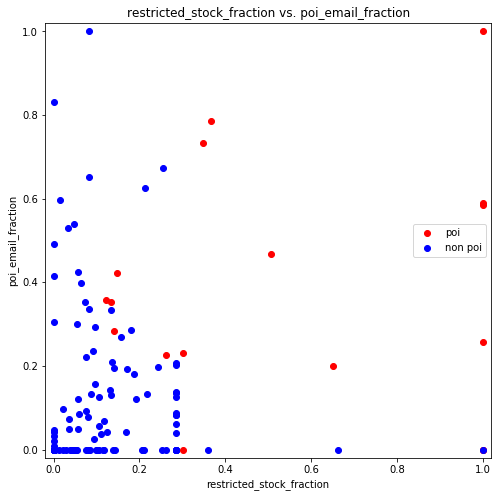

In [6]:
# poi fraction
data_df['restricted_stock_fraction'] = data_df['restricted_stock'] / data_df['total_stock_value']
data_df['poi_email_fraction'] = ((data_df['from_poi_to_this_person'] + data_df['from_this_person_to_poi']) / 
                                 (data_df['from_messages'] + data_df['to_messages']))

# visualization
scatter_plot(data_df, 'restricted_stock_fraction', 'poi_email_fraction')

By visualizing these new featuers one can see that all but one POI have a 'poi_email_fraction' equal to or larger than 0.2. The point that breaks ranks occurs as there is no email data for that person available. Most POIs have 'restricted_stock_fractions' between 0.2 and 0.7 but there are four data points that have all their stocks restricted.

## Algorithm Selection and Tuning


A lot of different classification algorithms could be applied to the identification of the POI labels. I focused on the following classifier selection: 

* Gaussian Naive Bayes
* Support Vector Classifier
* KNeighbors Classifier
* Decision Tree Classifier
* Random Forest Classifier
* AdaBoost Classifier

Before starting with the actual training and testing of the models I want to clarify some machine learning concepts that will afterwards be used throughout the project.

#### Feature Scaling

As our features in the dataset take on a wide variety of values (ratios between 0 and 1 or stock options of \$ 100'000'000) it is important to apply some sort of feature scaling for a meaningful comparison. In my project I scaled the features using the `MinMaxScaler()` function. This approach simply defines the lowest value as 0, the largest value as 1 and distributes all other ones proportionally between them.

#### Classifier Evaluation

For the evaluation of our machine learning algorithms I used three different metrics. **Accuracy** stands for the number of correct predictions in relation to all predictions. As there are a lot of non-POI data points accuracy tends to be rather high for all the different models and we need to consider different scoring approaches. 

The **Recall** score counts the number of POI data points that were actually caught by the model compared to the total number of POIs in the set. 

**Precision** on the other hand is the ratio of correctly classified POIs to the total number of classified POIs. This score tells how precise our recall rate was.

Applied to our dataset and problem I would give the most weight to the recall score. It is important that all POIs are identified and it is not too bad if we start looking into people that are classified as POI but were actually innocent. Nevertheless, precision should be as high as possible.

#### Model Validation

In machine learning, **validation** describes the process of evaluating the trained model using a new test dataset. This should ensure that the model does not overfit to the specific training data but generalizes well to any dataset. Normal validation reduces the size of our dataset by the percentage of data used for testing and thus decreases the amount of training data. To avoid this, **cross-validation** takes it a step further. It divides the dataset into a number of subsets and uses all the different combinations for training and testing.

Since the dataset for this project is imbalanced, meaning that there are a lot more non-POI data points than POI ones, I used the `StratifiedShuffleSplit()` method to create 100 random folds of different training and test sets with a test size of 33% each. Using this method ensures that each fold preserves the percentage of samples for both classes. Otherwise we might end up with train or test samples that do not contain any POI data points. By splitting the data into training and test set multiple times we try to assess model performance independently of the performed split. For each fold, the scores were evaluated and a mean score was calculated.

### Initial Screening

In a first screening step I used all the features from the dataset to train and test the six different classifiers. 
The mean metric values for all the different models are reported in the table below.

In [7]:
def get_classifier_scores(clf, X, y, random_state=None):
    """Train classifier and evaluate its accuracy, precision and recall score. 
    Uses 100 stratified and shuffled splits with a split ratio of 33% for 
    crross-validation and calculates the mean values for each metric.

    Args:
        clf: Scikit-learn classifier object.
        X: Feature numpy array or DataFrame.
        y: Label numpy array Dataframe.
        random_state: Seed for randomizer in the StratifiedShuffleSplit()
            function.

    Returns:
        List containing the mean accuracy, precision and recall for the 
        evaluated classifier.

        [accuracy, precision, recall]
    """
    
    # check if data set is in a dataframe, if so convert it to a numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    
    accuracies, precisions, recalls = [], [], []
    sss = StratifiedShuffleSplit(n_splits=100, test_size=0.33, random_state=42)
    
    for train_ixs, test_ixs in sss.split(X, y):
        X_train, X_test = X[train_ixs, :], X[test_ixs, :]
        y_train, y_test = y[train_ixs] , y[test_ixs]
    
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        accuracies.append(clf.score(X_test, y_test))
        precisions.append(precision_score(y_test, pred))
        recalls.append(recall_score(y_test, pred))
    
    return [np.mean(accuracies), np.mean(precisions), np.mean(recalls)]


def get_multi_classifier_scores(names, classifiers, X, y, random_state=None):
    """Calculate the accuracy, precision and recall scores for multiple 
    classifiers. Uses 100 stratified and shuffled splits with a split ratio of 
    33% for crross-validation and calculates the mean values for each metric.

    Args:
        names: List of classifier names.
        classifiers: List of scikit-learn classifier objects.
        X: Feature numpy array or DataFrame.
        y: Label numpy array Dataframe.
        random_state: Seed for randomizer in the StratifiedShuffleSplit()
            function.

    Returns:
        Dictionary containing dictionairies for each classifier name key with
        accuracy, precision and recall key-value pairs.

        {clf_name1: {accuracy: ..., precision: ..., recall: ...},
         clf_name2: {...}, 
         ...}
    """
    
    clf_scores = OrderedDict()
    for n, clf in zip(names, classifiers):
        clf_scores[n] = OrderedDict()
        scores = get_classifier_scores(clf, X, y, random_state=random_state)
        
        clf_scores[n]['accuracy'] = scores[0]
        clf_scores[n]['precision'] = scores[1]
        clf_scores[n]['recall'] = scores[2]
    
    return clf_scores

# data preparation
scaler = MinMaxScaler()
X = scaler.fit_transform(data_df.ix[:, (data_df.columns != 'name') & 
                                    (data_df.columns != 'email_address') &
                                    (data_df.columns != 'poi')].fillna(value=0))
y = data_df['poi'].astype(int)

# classifier names and objects    
names = ['Gaussian NB Classifier', 'Support Vector Classifier', 'KNeighbors Classifier', 
         'Decision Tree Classifier', 'Random Forest Classifier', 'AdaBoost Classifier']
classifiers =[GaussianNB(),
              SVC(random_state=42),
              KNeighborsClassifier(),
              DecisionTreeClassifier(random_state=42),
              RandomForestClassifier(random_state=42),
              AdaBoostClassifier(random_state=42)]

# create score overview table
scores = get_multi_classifier_scores(names, classifiers, X, y, random_state=42)
print_classifier_table(scores)

Classifier                 Accuracy  Precision  Recall  
--------------------------------------------------------
Gaussian NB Classifier     0.4873    0.1761     0.715   
Support Vector Classifier  0.875     0.0        0.0     
KNeighbors Classifier      0.8627    0.1398     0.0317  
Decision Tree Classifier   0.8085    0.252      0.2617  
Random Forest Classifier   0.865     0.2652     0.0933  
AdaBoost Classifier        0.8371    0.3053     0.25    


The table above shows that most algorithms, except for the Gaussian Naive Bayes classifier, achive very similar accuracy scores. This can be attributed to the number of non POIs that are classified correctly. But looking at precsion and recall we can already see major differences between the models. The lowest scores were achived using support vector and k-nearest neighbors classification. Surprisingly, the Gaussian Naive Bayes classifier showed the highest recall score without any fine tuning. But comparing it to the low precision value, we can say that the Gaussian Naive Bayes model recognizes most POIs but also wrongly suspects a lot of non-POIs.

### Feature Selection

So far I have used all the features for model training. There are two main reasons why this could be a bad approach. First of all, the more features are used, the more noise is present in the data. Therefore reducing feature numbers can decrease overfitting by ignoring some of that noise. Furthermore, using less data allows to train algorithms much faster. This is not a big problem in this case as we use a rather small dataset but should still be considered.

To find the features who correlate the most with the 'poi' label, I used the univariate `SelectKBest()` method from the `sklearn` package. This algorithms selects the top k features that score best in certain univariate statistical tests. I varied the parameter k between one and the total number of features (21) to see which value produces the best results for each classifier.

The model performances as a function of k are visualized in the plots below.

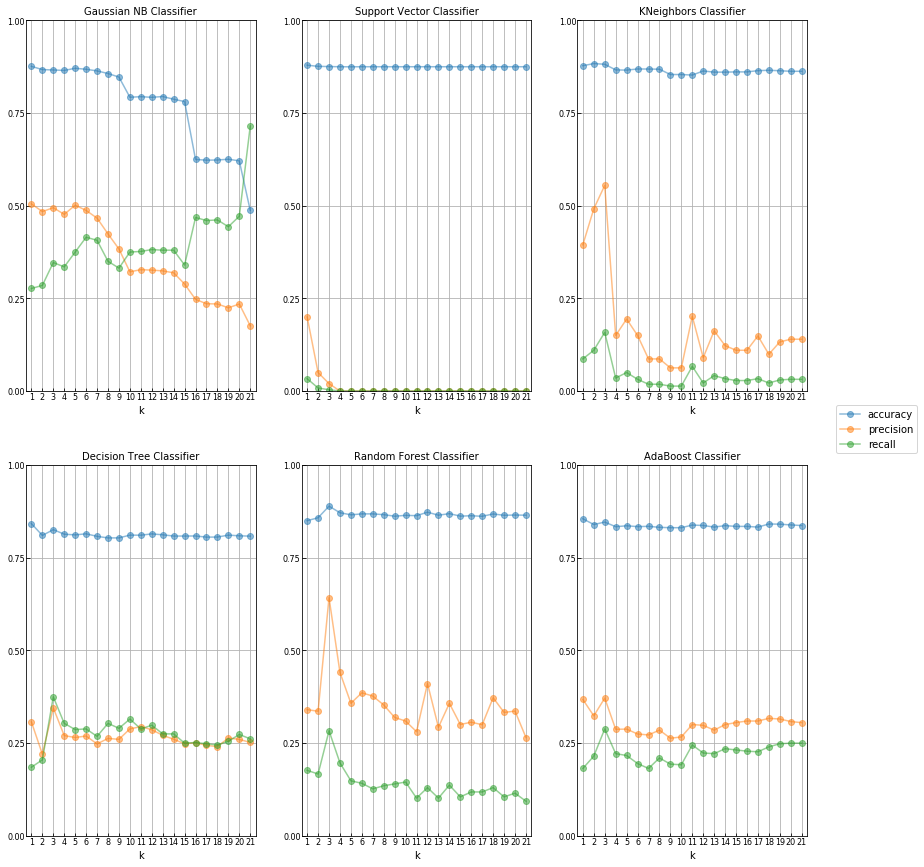

In [8]:
# dictionary to store all results
clf_scores = {}
for n in names:
    clf_scores[n] = {"accuracy": [], 'precision': [], 'recall': []}

# loop trough different k values
for k in range(1, len(X[1]) + 1):
    X_k = SelectKBest(k=k).fit_transform(X, y)
    scores = get_multi_classifier_scores(names, classifiers, X_k, y, random_state=42)
    
    # aggregate the different metrics in the results dictionary for easy plotting
    # afterwards
    for n, score in scores.items():
        accuracy = score['accuracy']
        precision = score['precision']
        recall = score['recall']
        
        clf_scores[n]['accuracy'].append(accuracy)
        clf_scores[n]['precision'].append(precision)
        clf_scores[n]['recall'].append(recall)

# visualize metrics for all algorithms
fig, axs = plt.subplots(2, 3, figsize=(14, 15))
k = np.arange(1, len(X[1]) + 1)

for ax, title in zip(axs.flatten(), names):
    for m in sorted(clf_scores[title].keys()):
        ax.plot(k, clf_scores[title][m], label=m, marker='o', alpha=0.5)
        ax.set(xlim=[0.5, 21.5], xticks=k, ylim=[0.0, 1.0], yticks=np.arange(0, 1.1, 0.25))
        ax.set_xlabel("k", fontsize=10)
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8, direction='in', pad=1)
        ax.grid()
        
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.175))
plt.show()

The performance of the Gaussian Naive Bayes classifier strongly depends on the value of k. In the plot one can see a big trade off between accuracy and precision versus recall. I think by using too many features, this algorithm overfits to the training data and hence recognizes most POIs (high recall) but also classifies a lot of non-POIs incorrectly (low accuracy and precision). The Support Vector classifier shows the worst results of all models. For k values larger than 3, both precision and recall decrease to 0. Both the KNeighbors and the Random Forest classifiers peak for k equal to 3 and show lower scores for higher feature numbers. The metrics of the Decision Tree as well as the AdaBoost classifiers seem to be the least affected by k.

### Parameter Tuning

Most machine learning models require intrinsic parameters that need to be set before the actual model training happens. These parameters are usually called hyperparameters. In this context, **parameter tuning** describes the process of finding the hyperparameter set that ensures optimal model performance. I used sklearns `GridSearchCV()` function to achieve this. It allows to do an exhaustive search over all the provided input parameters for an estimator and returns the parameter combination that achieved the best evaluation score. As optimization needs to focus on a specific scoring metric, I repeated parameter optimization for both precision and recall. For this first parameter screening, I have used all the features in the data set.

As the Gaussian Naive Bayes classifier does not require any hyperparameters, it was excludes from this step. Its optimal setup will solely base on k.

The optimum parameter and classifier combinations can be found in the printout below.

In [9]:
def find_best_parameters(names, classifiers, X, y, param_grid, score='accuracy', random_state=None):
    """Exhaustive search over specified parameter values for passed classifiers 
    optimizing based on the specified scoring metric.
    
    Args:
        names: List of classifier names.
        classifiers: List of scikit-learn classifier objects.
        X: Feature numpy array or DataFrame.
        y: Label numpy array Dataframe.
        param_grid: Dictionary of parameter dictionaries. The keys have to be
            equal to the entries in the names list.
        score: Scoring metric. Can be set to 'accuracy', 'precision' or
            'recall'.
        random_state: Seed for randomizer in the StratifiedShuffleSplit()
            function.

    Returns:
        Dictionary containing dictionairies for each classifier name key with
        the optimally performing parameter set and the corresponding score.

        {clf_name1: {parameters: {p1: v1, p2: v2, ...}, score: ...},
         clf_name2: {...}, 
         ...}
    """
    
    # check if data set is in a dataframe, if so convert it to a numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    
    clf_scores = OrderedDict()
    
    for n, clf in zip(names, classifiers):
        clf_scores[n] = OrderedDict()

        cv = StratifiedShuffleSplit(n_splits=100, test_size=0.33, 
                                    random_state=random_state)
        clf = GridSearchCV(clf, param_grid[n], cv=cv, scoring=score)
        clf.fit(X, y)
        
        clf_scores[n]['parameters'] = clf.best_params_
        clf_scores[n][score] = clf.best_score_
    
    return clf_scores


# parameter dictionary
param_grid = {'Support Vector Classifier': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
              'KNeighbors Classifier': {'n_neighbors': [2, 5, 10, 20],
                                        'weights': ['uniform', 'distance'],
                                        'algorithm': ['ball_tree', 'kd_tree', 'brute']},
              'Decision Tree Classifier': {'criterion': ['gini', 'entropy'], 
                                           'min_samples_split': [2, 5, 10, 20]},
              'Random Forest Classifier': {'n_estimators': [5, 10, 20, 50, 100], 
                                           'criterion': ['gini', 'entropy'], 
                                           'min_samples_split': [2, 5, 10, 20]},
              'AdaBoost Classifier': {'n_estimators': [5, 10, 20, 50, 100]}}

# optimize precision
precision_scores = find_best_parameters(names[1:], classifiers[1:], X, y, param_grid, score='precision', 
                                        random_state=42)
print_classifier_table(precision_scores)
print()

# optimize recall
recall_scores = find_best_parameters(names[1:], classifiers[1:], X, y, param_grid, score='recall', random_state=42)
print_classifier_table(recall_scores)

Classifier                 Parameters                                                           Precision  
-----------------------------------------------------------------------------------------------------------
Support Vector Classifier  {'C': 100}                                                           0.44       
KNeighbors Classifier      {'algorithm': 'ball_tree', 'weights': 'distance', 'n_neighbors': 2}  0.3127     
Decision Tree Classifier   {'criterion': 'gini', 'min_samples_split': 5}                        0.2651     
Random Forest Classifier   {'n_estimators': 50, 'criterion': 'gini', 'min_samples_split': 5}    0.3478     
AdaBoost Classifier        {'n_estimators': 20}                                                 0.3115     

Classifier                 Parameters                                                           Recall  
--------------------------------------------------------------------------------------------------------
Support Vector Classifier  {'C': 

Hyperparameter tuning increased the performances of all the models. The most significant increase could be observed for the Support Vector classifier. 

### Final Model Selection

In a last model selection step I tried to optimize the value of k (number and selection of input features) as well as the parameters simultaneously to find the best combinations and finally select the best performing model (running this exhaustive search takes a very long time).

In [10]:
def optimize_k_and_parameters(names, classifiers, X, y, param_grid, score='accuracy', random_state=None):
    """Find the optimum combination of classifier, number of top features to use
    and parameter settings. Optimization is based on the scoring metric passed.

    Args:
        names: List of classifier names.
        classifiers: List of scikit-learn classifier objects.
        X: Feature numpy array or DataFrame.
        y: Label numpy array Dataframe.
        param_grid: Dictionary of parameter dictionaries. The keys have to be
            equal to the entries in the names list.
        score: Scoring metric. Can be set to 'accuracy', 'precision' or
            'recall'.
        random_state: Seed for randomizer in the StratifiedShuffleSplit()
            function.
    Returns:
        Dictionary containing dictionairies for each classifier name key with
        the optimally performing parameter set, the optimum number of top 
        features to use and the corresponding score.

        {clf_name1: {parameters: {p1: v1, p2: v2, ...}, n: ..., score: ...},
         clf_name2: {...}, 
         ...}
    """

    # perform parameter optimization for varying number of input features
    clf_scores = OrderedDict()
    for k in range(1, len(X[1]) + 1):
        X_k = SelectKBest(k=k).fit_transform(X, y)
        
        scores = find_best_parameters(names, classifiers, X_k, y, param_grid, 
                                      score=score, random_state=random_state)
        clf_scores[k] = scores
    
    # select best results for each classifier
    clf_best_scores = OrderedDict()
    for n in names:
        clf_best_scores[n] = OrderedDict()
        best_score, best_k, best_params = 0, 0, None
        
        for i, v in clf_scores.items():
            for k, v in v.items():
                if k == n:
                    if v[score] > best_score:
                        best_score = v[score]
                        best_k = i
                        best_params = v['parameters']
        
        clf_best_scores[n]['k'] = best_k
        clf_best_scores[n]['parameters'] = best_params
        clf_best_scores[n][score] = best_score
            
    return clf_best_scores


# optimize precision scores by varying parameters and number of top input features
precision_scores = optimize_k_and_parameters(names[1:], classifiers[1:], X, y, param_grid, score='precision', 
                                             random_state=42)
print_classifier_table(precision_scores)
print()

# optimize recall scores by varying parameters and number of top input features
recall_scores = optimize_k_and_parameters(names[1:], classifiers[1:], X, y, param_grid, score='recall', 
                                          random_state=42)
print_classifier_table(recall_scores)

Classifier                 K  Parameters                                                            Precision  
---------------------------------------------------------------------------------------------------------------
Support Vector Classifier  1  {'C': 1000}                                                           0.685      
KNeighbors Classifier      3  {'algorithm': 'ball_tree', 'weights': 'distance', 'n_neighbors': 5}   0.5924     
Decision Tree Classifier   1  {'criterion': 'gini', 'min_samples_split': 20}                        0.3997     
Random Forest Classifier   3  {'n_estimators': 20, 'criterion': 'entropy', 'min_samples_split': 5}  0.6611     
AdaBoost Classifier        1  {'n_estimators': 5}                                                   0.5523     

Classifier                 K   Parameters                                                           Recall  
----------------------------------------------------------------------------------------------------------

Based on these optimisations, I would say that the KNeighbors, Random Forest and AdaBoost classifiers performed the best. The Decision Tree classifier achieved the highest recall score but its precision is significantly lower than the ones of the other models. As I determined recall to be the most important metric for the model I selected the conditions found by recall optimization.

Before continuing, I also wanted to include the Gaussian Naive Bayes model for futher considerations. In the performance plot derived by the variation of k, one can see that the recall rate reaches a local optima for k = 6 while accuracy and precision are still reasonably high.

In conclusion, the four best performing models, their k values and parameter settings are summarized in the table below:

| Model                    | k | Parameters |
|--------------------------|---|------------|
| Gaussian Naive Bayes     | 6 | None       |
| KNeighbors Classifier    | 3 | <ul><li>n_neighbors: 2</li><li>weights: distance</li><li>algorithm: ball_tree</li>/ul> |
| Random Forest Classifier | 3 | <ul><li>min_samples_split: 2</li><li>n_estimators: 5</li><li>criterion: gini</li></ul> |
| AdaBoost Classifier      | 3 | <ul><li>n_estimators: 100</li></ul> |


Let us see with what features these k values correspond.

In [11]:
# data preparation
X = data_df.fillna(value=0).select_dtypes(include=[np.number])
y = data_df['poi'].astype(int)

# determine feature names for k = 3
for k in [3, 6]:
    selector = SelectKBest(k=k)
    selector.fit(X, y)

    features = X[selector.get_support(indices=True)].columns.values
    scores = selector.scores_
    score_list = sorted([(f, s) for f, s in zip(features, scores)], key=lambda tup: tup[1], reverse=True)

    # print out scoring table
    print("k = {}".format(k))
    print("{:<25} {:<10}".format("Feature", "Score"))
    print("-------------------------------")
    for tup in score_list: 
        print("{:<25} {}".format(tup[0], round(tup[1], 2)))
    print()

k = 3
Feature                   Score     
-------------------------------
bonus                     20.79
total_stock_value         11.46
exercised_stock_options   0.22

k = 6
Feature                   Score     
-------------------------------
salary                    24.82
bonus                     20.79
exercised_stock_options   11.46
total_stock_value         6.09
long_term_incentive       2.13
deferred_income           0.22



Looking at the feature names, one can see that none of my additionally engineered features appear in the list and thus they did not help to improve the performance of the POI identifiers. All the three features selected when k = 3 also appear in the list for k = 6. Surprisingly, 'salary' which achieved the highest selection score for k equal to 6 does not appear in the other list. 

Using these settings, I calculated all three evaluation metrics to select my final best model.

In [12]:
# data preparation
scaler = MinMaxScaler()
X = scaler.fit_transform(data_df.ix[:, (data_df.columns != 'name') & 
                                    (data_df.columns != 'email_address') &
                                    (data_df.columns != 'poi')].fillna(value=0))
y = data_df['poi'].astype(int)

# model definition
top_names = ['Gaussian NB Classifier', 'KNeighbors Classifier', 'Random Forest Classifier', 'AdaBoost Classifier']
top_classifiers =[GaussianNB(),
                  KNeighborsClassifier(n_neighbors=2, weights='distance', algorithm='ball_tree'),
                  RandomForestClassifier(min_samples_split=2, n_estimators=5, criterion='gini', random_state=42),
                  AdaBoostClassifier(n_estimators=100, random_state=42)]
top_ks = [6, 3, 3, 3]

# evaluate models
scores = []
for clf, k in zip(top_classifiers, top_ks):
    X_k = SelectKBest(k=k).fit_transform(X, y)
    
    scores.append(get_classifier_scores(clf, X_k, y, random_state=42))   

# create score table
clf_scores = OrderedDict()
for n, score in zip(top_names, scores):
    clf_scores[n] = OrderedDict()
    clf_scores[n]['accuracy'] = score[0]
    clf_scores[n]['precision'] = score[1]
    clf_scores[n]['recall'] = score[2]
    
print_classifier_table(clf_scores)

Classifier                Accuracy  Precision  Recall  
-------------------------------------------------------
Gaussian NB Classifier    0.8681    0.4872     0.415   
KNeighbors Classifier     0.8404    0.3755     0.355   
Random Forest Classifier  0.8771    0.5282     0.3217  
AdaBoost Classifier       0.8406    0.3497     0.315   


All the remaining four classifiers achieved very similar accuracy scores. Both the Gaussian NB as well as the Random Forest classifier achieved precision scores around 50%. But looking at recall, one can see that the Gaussian NB model outperformed all the other ones.

Hence, the Gaussian NB classifier using six input features: 

* **salary**
* **bonus**
* **excercised_stock_options**
* **total_stock_value**
* **long_term_incentive**
* **deferred_income**

is my final model pick. The performance metrics above show that this model classifed 86% of all people correctly. Of all the people it classified as POIs, 48% are actually POIs and 42% of all the POIs in the data set were caught by the model.

## PCA Approach

Instead of selecting the features that influence target labels the most one can use principal component analysis (PCA) for dimensionality reduction and condense all features into linearly uncorrelated variables. In a last part of my project, I wanted to see if can achieve better results using PCA than selecting individual input features.

For this, I transformed the features into two to twenty-one principal components and calculated the three evaluation metrics for the clasifier models and plotted the results versus the number of principal components. All the default hyperparameter values were used for this.

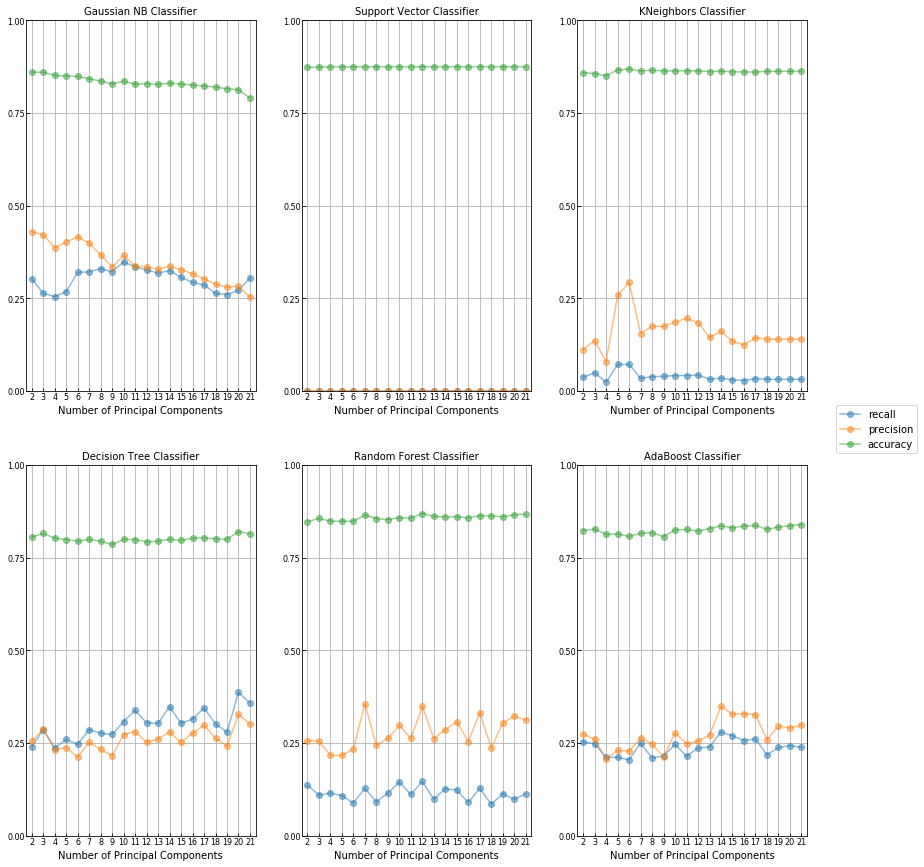

In [13]:
# calculate evalutation metrics for 1 to 10 principal components
# dictionary to store all results
clf_scores = {}
for n in names:
    clf_scores[n] = {"accuracy": [], 'precision': [], 'recall': []}

for n_pc in range(2, len(X[1]) + 1):
    pca = PCA(n_components=n_pc)
    X_pca = pca.fit_transform(X)
    
    scores = get_multi_classifier_scores(names, classifiers, X_pca, y, random_state=42)
    for n, score in scores.items():
        accuracy = score['accuracy']
        precision = score['precision']
        recall = score['recall']
        
        clf_scores[n]['accuracy'].append(accuracy)
        clf_scores[n]['precision'].append(precision)
        clf_scores[n]['recall'].append(recall)

# visualize metrics for all algorithms
fig, axs = plt.subplots(2, 3, figsize=(14, 15))
n_pc = np.arange(2, len(X[1]) + 1)

for ax, title in zip(axs.flatten(), names):
    for m in clf_scores[title].keys():
        ax.plot(n_pc, clf_scores[title][m], label=m, marker='o', alpha=0.5)
        ax.set(xlim=[1.5, 21.5], xticks=n_pc, ylim=[0.0, 1.0], yticks=np.arange(0, 1.1, 0.25))
        ax.set_xlabel("Number of Principal Components", fontsize=10)
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8, direction='in', pad=1)
        ax.grid()

plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.175))
plt.show()

The classifiers show similarly high accuracy scores compared to the results without PCA. The Gaussian NB classifier shows a much more stable behaviour. For large numbers of principal components, all three metrics only slightly decrease. The Support Vector model does barely recognize any POIs using PCA. The other models behaved very similar but generally achieved lower scores compared to the case where I used individual feature selection. 

As I did not observe any major performance improvements when using PCA I did not follow trough with further optimisation steps. But before finishing this project up, I wanted to have a look at the decision boundaries of the models when using only two principal components as one can visualize them in a two dimensional plot for this specific case.

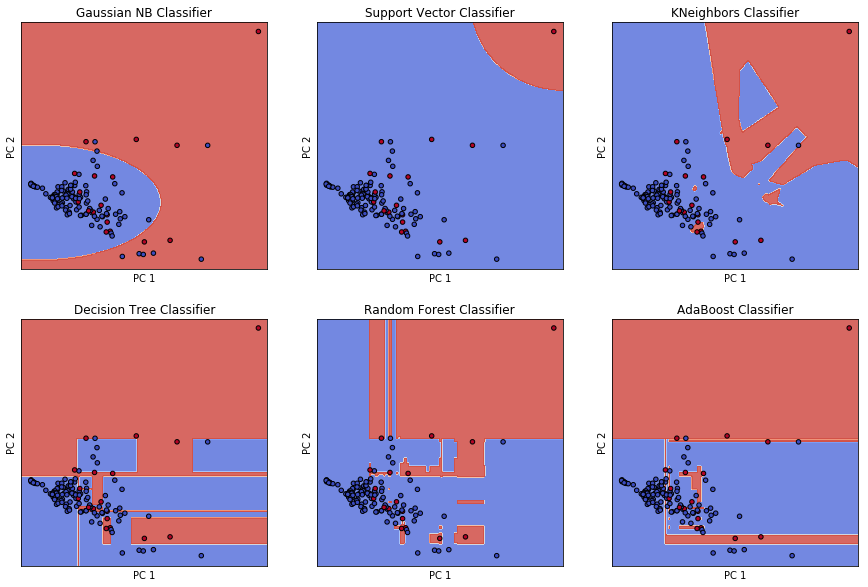

In [14]:
# pca transformation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# set up 2x3 grid for plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# generate meshgrid
X0, X1 = X_pca[:, 0], X_pca[:, 1]
xx, yy = generate_meshgrid(X0, X1)

# create scatter plot and decision boundary
for ax, title, clf in zip(axs.flatten(), names, classifiers):
    clf.fit(X_pca, y.values)
    plot_boundaries(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set(title=title,
           xlabel='PC 1', xlim=[xx.min(), xx.max()], xticks=[], 
           ylabel='PC 2', ylim=[yy.min(), yy.max()], yticks=[])

plt.show()

The Gaussian Naive Bayes classifier creates an elliptical decision boundary that that does not seem very good at separating the cluster that contains most data points but recognizes most POIs that lay farther outside. The SVC model only finds the POI in the upper right corner. The KNeighbors algorithm creates a more complex boundary but still performs very poorly. The other three models show somewhat more complicated decision boundaries but achive very similar results. They catch most POIs in the top right area but fail to classify all people in the clustered lower left corner.

## Conclusion

In this project I analysed email and financial data that was made public during the Enron fraud trial. Goal was to build a classifier that reliably identifies persons of interest.

I started by having a closer look at the dataset. I investigated missing values, removed outliers, created two new features and selected the features influencing the POI status the most.

Afterwards, I experimented with various classifer, feature and parameter combinations until I found the one scoring the highest recall and precision scores. As the dataset is heavily imbalanced (much more non-POI data points than POI ones) cross-validation is an important tool to ensure that the model does not overfit but generalizes well independently of the training and test data split.

Before determining the best classifier, I also wanted to see if using PCA instead of selecting individual input features deliveres better prediction results. I varied the number of principal components between two and twenty-one (total number of features) but could not observe increased performance.

Finally, I ended up with a Gaussian Nive Bayes classifier using **salary**, **bonus**, **exercised_stock_options**, **total_stock_value**, **long_term_incentive**, and **deferred_income** as input features. Here it has to be mentioned that none of my additionally engineered features appear in this final list.

With this setup I achieved an **accuracy** of 86%, a **precision** of 48% and a **recall** rate of 42%.